# Train 1D CNN

Code and helper functions to train the 1D CNN model and check accuracies.

In [ ]:
# Define Parameters
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import time

def test_accuracy(model, test_loader, input_size, device, loss_function):
    model.to(device)
    correct = 0
    total_loss = 0
    total = 0
    with torch.no_grad():
        for test_data in test_loader:
            images, labels = test_data[0].cuda(), test_data[1].cuda()
            images = images.view(-1, input_size)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += len(images)
            correct += (predicted == labels).sum().item()

            # loss
            loss = loss_function(outputs, labels).item()
            total_loss += loss
    accuracy = 100 * correct / total
    loss = total_loss / len(test_loader) # avg loss is calculated for each item in test_loader
    # print('Accuracy: %d %%' % (100 * correct / total))
    # print('Loss: %.4f' % loss)
    return accuracy, loss

def train(model, loss_fn, optimizer, train_loader, test_loader, loss_function, batch_size, num_epochs, device):
    # Clear the contents of these global variables
    # train_losses.clear()
    # test_losses.clear()
    # train_accuracies.clear()
    # test_accuracies.clear()

    input_size = 385

    # Iterator
    dataiter = iter(test_loader)

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Variables for getting accuracy
        total_loss = 0 # per batch
        total_loss_ep = 0 # per epoch

        # Get a new test set every epoch
        val_imgs, val_labels = next(dataiter)
        val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
        # val_imgs = val_imgs.view(-1, input_size)

        for i, data in enumerate(train_loader):

            # Flatten images and load images/labels
            images, labels = data[0].cuda(), data[1].cuda()
            # images = images.view(-1, input_size)

            # Zero collected gradients at each step
            optimizer.zero_grad()

            # Forward Propagate
            outputs = model(images)

            # Calculate Train Loss
            loss = loss_function(outputs, labels)
            loss.backward()  # Back propagate
            optimizer.step()  # Update weights
            total_loss += loss.item()
            total_loss_ep += loss.item()

            # Calculating Val Loss
            val_outputs = model(val_imgs)
            val_loss = loss_fn(val_outputs, val_labels).item()

            # Print for every 2 iterations
            if (i + 1) % 2 == 0: # 200 to save time
              print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss}')
              # Only plot every 2
              meow_train_accuracy, _ = test_accuracy(model, train_loader, input_size, device, loss_fn)
              train_accuracies.append(meow_train_accuracy)
              meow_train_loss = total_loss / 2
              train_losses.append(meow_train_loss)

              meow_test_accuracy, meow_test_loss = test_accuracy(model, test_loader, input_size, device, loss_fn)
              test_accuracies.append(meow_test_accuracy)
              test_losses.append(meow_test_loss)

              # reset batch totals
              total_loss = 0

        # Calculating the avg train loss and train accuracy for the current epoch
        epoch_loss = total_loss_ep / len(train_loader)
        epoch_train_accuracy, _ = test_accuracy(model, train_loader, input_size, device, loss_fn)
        epoch_test_accuracy, _ = test_accuracy(model, test_loader, input_size, device, loss_fn)
        total_loss_ep = 0

        # Get the time taken for the epoch and print it
        epoch_duration = time.time() - epoch_start_time
        print(f"Epoch [{epoch+1}/{num_epochs}] End. Duration: {epoch_duration:.2f} seconds, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_train_accuracy}, Val Accuracy: {epoch_test_accuracy}\n")

def plot_learning_curve(train_accuracies, train_losses, test_accuracies, test_losses):
    epochs = list(range(1, len(train_losses) + 1))
    if len(train_losses) > len(train_accuracies):
      for i in range(len(train_losses) - len(train_accuracies)):
        train_accuracies.append(train_accuracies[-1]) # add this to not really change the curve
    if len(train_losses) > len(test_accuracies):
      for i in range(len(train_losses) - len(test_accuracies)):
        test_accuracies.append(test_accuracies[-1]) # add this to not really change the curve
    if len(train_losses) > len(test_losses):
      for i in range(len(train_losses) - len(test_losses)):
        test_losses.append(test_losses[-1]) # add this to not really change the curve

    fig, ax = plt.subplots(2)
    ax[0].plot(epochs, train_accuracies, label='train')
    ax[0].plot(epochs, test_accuracies, label='test')
    ax[0].set_ylabel('Accuracies')
    ax[1].plot(epochs, train_losses, label='train')
    ax[1].plot(epochs, test_losses, label='test')
    ax[1].set_ylabel('Loss')

    plt.xlabel('Batch Sample')
    fig.suptitle('Loss and Accuracies from Training')

    plt.show()

In [ ]:
# A simple single layer 1D CNN
# Inlcuded for intial testing to determine if a 1D CNN is the right model architecture to utilize.
import torch
import torch.nn as nn
import pandas as pd
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as utils
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

class Net(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(input_size, 500)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500, num_classes)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


input_size = 385 # TODO: Depends on how many time-segmented clips we pass in. ( was 250000)
num_classes = 2 # TODO: 6 (total including coarse and fine grain)?
lr = 0.01
num_epochs = 5   # TODO: Change?
batch_size = 32  # TODO: Change accordingly


In [ ]:
# Pulling data from CSV
from sklearn.model_selection import train_test_split

x_dataset= pd.read_csv(r"/content/couch_s1_window_amplitudes (1).csv", header=None)
print(x_dataset.shape)
y_dataset =  pd.read_csv(r"/content/couch_s1_binary_output (1).csv", header=None)
print(y_dataset.shape)
X_train, X_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.3, random_state=42)

print(f"x train length df: {X_train.shape}")
print(f"y train length df: {y_train.shape}")

print(f"x test length df: {X_test.shape}")
print(f"y test length df: {y_test.shape}")

(4765, 385)
(4765, 1)
x train length df: (3335, 385)
y train length df: (3335, 1)
x test length df: (1430, 385)
y test length df: (1430, 1)


In [ ]:
# Apply torch tensor
X_train = torch.tensor(X_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)
y_test = torch.tensor(y_test.values, dtype=torch.long)

# Squeeze the y data into a 1-dimensional value
squeezed_y_train = torch.squeeze(y_train)
squeezed_y_test = torch.squeeze(y_test)

# Make the data into a Tensor dataset
train_data = TensorDataset(X_train, squeezed_y_train)
test_data = TensorDataset(X_test, squeezed_y_test)
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [ ]:
# ECG-Net --> from mini project b2
class ECGNET(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ECGNET,self).__init__()

        # layer 1: convolutional
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=6, stride=1)

        # ReLU
        self.relu = nn.ReLU()

        # layer 2: batch normalization
        self.batch = nn.BatchNorm1d(num_features=64)

        # layer 3: max pooling
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        # layer 4: convolutional
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, stride=1)

        # layer 5: batch normalization
        # layer 6: max pooling
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=1)

         # dimensions
         # output size = ((input - kernel + 2*padding)//stride) + 1
        edge = int((input_size))
        conv1_out = ((edge - 6) // 1) + 1
        pool1_out = ((conv1_out - 1) // 2) + 1
        conv2_out = ((pool1_out - 3) // 1) + 1
        pool2_out = ((conv2_out) // 2) + 1

        # fully connected layer input
        fc_input_size = (pool2_out)*64

        self.input_dimension = input_size

        # layer 7: fully connected
        self.fc1 = nn.Linear(fc_input_size, 64)

        # layer 8: fully connected
        self.fc2 = nn.Linear(64,32)

        # layer 9: fully connected
        self.fc3 = nn.Linear(32, num_classes)


    def forward(self,x):
        x = x.view(-1,1,self.input_dimension)
        out = self.conv1(x)
        out = self.relu(out)

        out = self.batch(out)

        out = self.maxpool(out)

        out = self.conv2(out)
        out = self.relu(out)

        out = self.batch(out)

        out = self.maxpool2(out)

        # flatten
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)

        out = self.fc2(out)
        out = self.relu(out)

        out = self.fc3(out)
        return out

Epoch [1/5], Step [2/105], Train Loss: 0.4795, Val Loss: 1.3425809144973755
Epoch [1/5], Step [4/105], Train Loss: 1.0747, Val Loss: 1.465745210647583
Epoch [1/5], Step [6/105], Train Loss: 1.7959, Val Loss: 0.9609454870223999
Epoch [1/5], Step [8/105], Train Loss: 1.5678, Val Loss: 0.8288233280181885
Epoch [1/5], Step [10/105], Train Loss: 0.0018, Val Loss: 5.302594184875488
Epoch [1/5], Step [12/105], Train Loss: 2.3165, Val Loss: 2.061767339706421
Epoch [1/5], Step [14/105], Train Loss: 2.1323, Val Loss: 0.8895052075386047
Epoch [1/5], Step [16/105], Train Loss: 4.9757, Val Loss: 0.12131426483392715
Epoch [1/5], Step [18/105], Train Loss: 0.0363, Val Loss: 0.037033483386039734
Epoch [1/5], Step [20/105], Train Loss: 2.2190, Val Loss: 0.06633682548999786
Epoch [1/5], Step [22/105], Train Loss: 0.0136, Val Loss: 0.1361376941204071
Epoch [1/5], Step [24/105], Train Loss: 0.6590, Val Loss: 0.23965123295783997
Epoch [1/5], Step [26/105], Train Loss: 0.5039, Val Loss: 0.34856322407722473


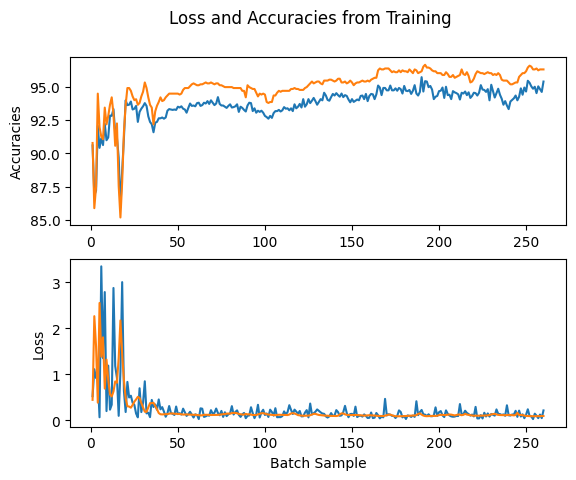

(96.36363636363636, 0.09798417244520452)

In [ ]:
# Instantiate 1-Layer Model
input_size = 385
# net = Net(input_size, num_classes)
net = ECGNET(input_size, num_classes=2).cuda()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net.to(device)
if not torch.cuda.is_available():
  raise Exception("Cuda is not available. Try again later.") # Just to not waste time!

# Define Loss func and Optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
# optimizer = torch.optim.SGD(net.parameters(), momentum=0.5, lr=0.01)

# Train Model
train(net, loss_function, optimizer, train_loader, test_loader, loss_function, batch_size, num_epochs, device)
print(train_accuracies)

# Plot Learning Curves
plot_learning_curve(train_accuracies, train_losses, test_accuracies, test_losses)

# Evaluate on Test Set
test_accuracy(model=net, test_loader=test_loader, input_size=input_size, device = device, loss_function=loss_function)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader, device, classes, title):
      image_labels = []
      predictions = []

      correct = 0
      total = 0
      with torch.no_grad():
          for test_data in test_loader:
              images, labels = test_data[0].cuda(), test_data[1].cuda()
              outputs = model(images)
              _, predicted = torch.max(outputs.data, 1)
              predictions.extend(predicted.cpu().numpy())
              image_labels.extend(labels.cpu().numpy())

      # Compute the confusion matrix
      matrix = confusion_matrix((image_labels), (predictions), labels=range(len(classes)))
      print(predictions)

      # Normalize the confusion matrix taken from https://www.geeksforgeeks.org/how-to-normalize-a-confusion-matrix/
      matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

      square = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=classes)
      square.plot(cmap=plt.cm.Blues)
      plt.title(title)
      plt.show()

x train length df: (82, 385)
y train length df: (82, 1)
Predictions:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0]
Truth:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0]


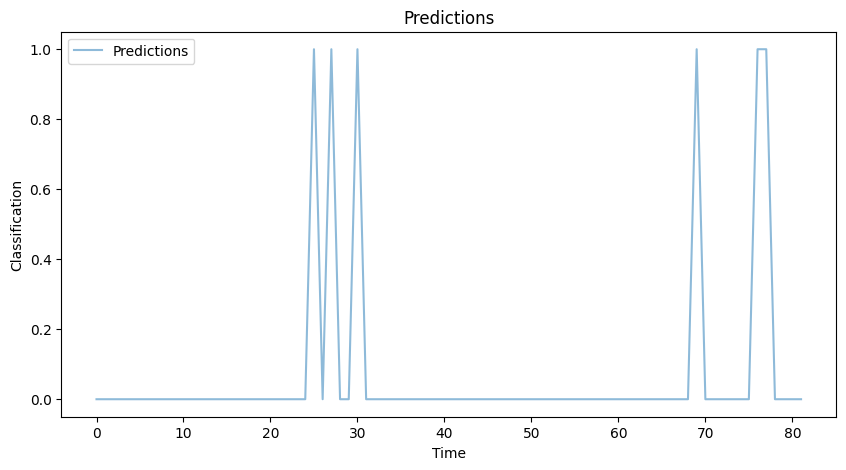

82
Accuracy: 85.37%


In [ ]:
# create test loader with one signal
signal_x_data = pd.read_csv(r"/content/couch_predict_amps.csv", header=None) # test amps
signal_y_data =  pd.read_csv(r"/content/couch_predict_binary.csv", header=None) # test binary

print(f"x train length df: {signal_x_data.shape}")
print(f"y train length df: {signal_y_data.shape}")


signal_amps = torch.tensor(signal_x_data.values, dtype=torch.float32)
signal_binary = torch.tensor(signal_y_data.values, dtype=torch.long)
squeezed_binary = torch.squeeze(signal_binary)

signal_test = TensorDataset(signal_amps, squeezed_binary)
signal_test_loader = DataLoader(dataset = signal_test, batch_size = batch_size, shuffle = False)

image_labels = []
predictions = []
correct = 0
total = 0
with torch.no_grad():
    for test_data in signal_test_loader:
        images, labels = test_data[0].cuda(), test_data[1].cuda()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())
        image_labels.extend(labels.cpu().numpy())

print("Predictions: ", predictions)
print("Truth: ", image_labels)

plt.figure(figsize=(10, 5))
plt.plot(predictions, alpha=0.5, label="Predictions")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Classification")
plt.title("Predictions")
plt.show()

print(len(predictions))


matched = 0
for val in range(len(image_labels)):
  if predictions[val] == image_labels[val]:
    matched+=1
  else:
    continue

accuracy = matched/len(predictions)
print(f"Accuracy: {accuracy:.2%}")

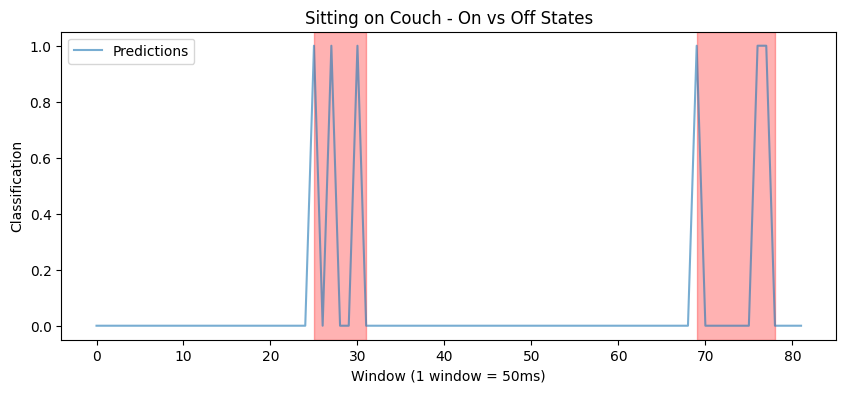

In [ ]:
# Detect state transitions
on_periods = []
current_state = 0
start_time = None

for i in range(len(predictions)):
  if predictions[i] == 1 and current_state == 0:  # 0 --> 1
      start_time = i
      current_state = 1
  elif predictions[i] == 0 and current_state == 1:  # 1 --> 0
      on_periods.append((start_time, i))
      current_state = 0

# Merge close intervals (less than 15 units apart)
merged_intervals = []
for start, end in on_periods:
    if merged_intervals and (start - merged_intervals[-1][1] < 15):
        # Merge with the previous interval
        merged_intervals[-1] = (merged_intervals[-1][0], end)
    else:
        merged_intervals.append((start, end))

# Convert to dataframe
on_periods_df = pd.DataFrame(merged_intervals, columns=["Start", "End"])
on_periods_df["Duration"] = on_periods_df["End"] - on_periods_df["Start"]

# Plot results
plt.figure(figsize=(10, 4))
plt.plot(predictions, label="Predictions", alpha=0.6)
for start, end in merged_intervals:
    plt.axvspan(start, end, color="red", alpha=0.3)  # Highlight "on" periods

plt.xlabel("Window (1 window = 50ms)")
plt.ylabel("Classification")
plt.title("Sitting on Couch - On vs Off States")
plt.legend()
plt.show()


In [ ]:
# Export predictions to CSV for demo purposes.

import csv
file_path = '/content/couch_output_predictions.csv'
with open(file_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(predictions)

In [ ]:
# Print detected "on" periods
# print(on_periods_df)

for i in range(len(on_periods_df)):
  print(f"Action detected {i+1}: Start: {on_periods_df.iloc[i][0]*385/7700} secs, End: {on_periods_df.iloc[i][1]*385/7700} secs, Duration: {on_periods_df.iloc[i][2]*385/7700} secs")

print("\nTotal Breakdown: ----------------------")
print(f"- Total Actions detected: {len(on_periods_df)}\n")


Action detected 1: Start: 1.25 secs, End: 1.55 secs, Duration: 0.3 secs
Action detected 2: Start: 3.45 secs, End: 3.9 secs, Duration: 0.45 secs

Total Breakdown: ----------------------
- Total Actions detected: 2



<ipython-input-50-16e5bdc66d41>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Action detected {i+1}: Start: {on_periods_df.iloc[i][0]*385/7700} secs, End: {on_periods_df.iloc[i][1]*385/7700} secs, Duration: {on_periods_df.iloc[i][2]*385/7700} secs")


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 

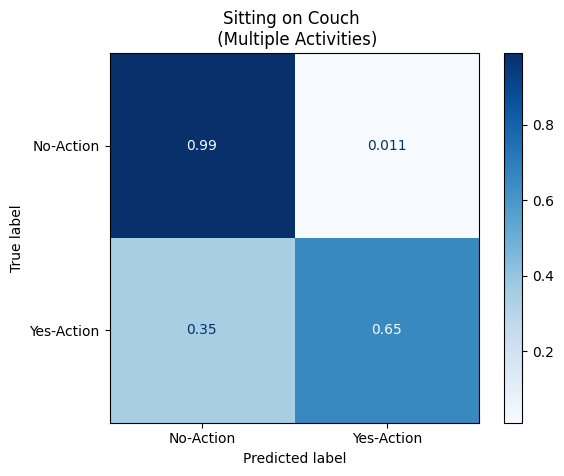

In [ ]:
# Observe confusion matrix
class_given =['No-Action', 'Yes-Action']

plot_confusion_matrix(model=net, test_loader=test_loader, device=device, classes=class_given, title = "Sitting on Couch \n (Multiple Activities)")